# Epidemic simulation on a graph 
## Matteo Merlo s287576

## Main Code section

In [141]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt

In [173]:
# SIR (SIRV) model plot
def sir_plot(s, i, r, v=[], file=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    ticks = np.arange(0, s.shape[0], dtype=int)

    ax.plot(ticks, s, label="S", color="blue", marker=".")
    ax.plot(ticks, i, label="I", color="red", marker=".")
    ax.plot(ticks, r, label="R", color="green", marker=".")
    if len(v) > 0:
        ax.plot(ticks, v, label="V", color="turquoise", marker=".")

    ax.set_xticks(ticks)
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of nodes (people)')
    ax.grid(alpha=0.3)
    ax.legend()

    if file:
        plt.savefig(file)
    else:
        plt.show()

# new infection model plot
def ni_plot(ni, file=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    ticks = np.arange(0, ni.shape[0], dtype=int)

    ax.plot(ticks, ni, color="red", marker=".")

    ax.set_xticks(ticks)
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of newly infected nodes')
    ax.grid(alpha=0.3)

    if file:
        plt.savefig(file)
    else:
        plt.show()
        
# new infection-vaccination model plot
def ninv_plot(ni, nv, file=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    ticks = np.arange(0, ni.shape[0], dtype=int)

    ax.plot(ticks, ni, color="red", label="newly I", marker=".")
    ax.plot(ticks, nv, color="turquoise", label="newly V", marker=".")

    ax.set_xticks(ticks)
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of nodes')
    ax.grid(alpha=0.3)
    ax.legend()

    if file:
        plt.savefig(file)
    else:
        plt.show()
        
# plot comparison between new infection simulated and predicted
def ni_comparison_plot(ni, ni_target, file=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    ticks = np.arange(0, ni.shape[0], dtype=int)

    ax.plot(ticks, ni, color="red", label="newly I (simulation)", marker=".")
    ax.plot(ticks, ni_target, color="black", label="newly I (real)", linestyle="--")

    ax.set_xticks(ticks)
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of nodes')
    ax.grid(alpha=0.3)
    ax.legend()

    if file:
        plt.savefig(file)
    else:
        plt.show()

In [143]:
# Generate a symmetric k-regular graph with n nodes and k neighbors of each node
def generator_k_regular_graph(n, k):
    
    if (k > n) or (n <= 0) or (k <= 1):
        raise ValueError("Invalid parameters")

    nodes = list(range(n))
    edges = []

    if k % 2 != 0:
        k = k-1

    relative_neighbors = np.concatenate([np.arange(-k/2, 0), np.arange(1, k/2+1)])

    for node in nodes:
        for neighbor in relative_neighbors:
            # Add an edge between each node and the four nodes whose index is closest to the node's own index
            edges.append((node, nodes[(node + int(neighbor)) % n]))

    graph = nx.Graph()
    graph.add_nodes_from(nodes)  # Needed to keep nodes in ascending order
    graph.add_edges_from(edges)
#     nx.draw_circular(graph)

    return graph

# Generate a random graph according to the preferential attachment model.
def generator_preferential_attachment(nodes, k_degree):
    
    if (k_degree > nodes) or (nodes <= 0) or (k_degree <= 1):
        raise ValueError("Invalid parameters")

    graph = nx.complete_graph(k_degree+1, nx.DiGraph())
    
    degree_sequence = sorted([d for n, d in graph.out_degree()], reverse=True)
    
    cf = math.floor(k_degree/2)
    cc = math.ceil(k_degree/2)
    
    for node in range(k_degree+1, nodes):
    
        in_deg = np.array([d for n, d in graph.in_degree()])
        in_deg_p = in_deg/sum(in_deg)
    
        if node%2 == 0:
            connect_nodes = np.random.choice(range(len(in_deg)),p=in_deg_p, size=cf, replace=False) 
        else:
            connect_nodes = np.random.choice(range(len(in_deg)),p=in_deg_p, size=cc, replace=False) 
        
        for cn in connect_nodes:
            graph.add_edge(cn, node)
            graph.add_edge(node, cn) 
            
    return graph

# Generate a graph according to the newman-watts-strogatz model.
def generator_newman_watts_strogatz(nodes, k_degree, prob = 0.5):
    
    if (k_degree > nodes) or (nodes <= 0) or (k_degree <= 1):
        raise ValueError("Invalid parameters")
        
    graph = nx.newman_watts_strogatz_graph(nodes, k_degree, prob)
    return graph

In [144]:
"""Simulate an epidemic in discrete-time SIR model or SIRV model with vaccinations.
   Possible states:
   S = 0
   I = 1
   R = 2
   V = 3

    Args:
        graph: the graph where the simulation take place
        beta: probability that the infection is spread from an infected individual to a susceptible one, 
            given that they are connected by a link, during one time step
        rho: probability that an infected individual will recover during one time step
        n_weeks: number of weeks through the simulation take place, number of steps of simulation
        n_infected_init: number of infected nodes in the initial configuration, 
            chosen randomly among all nodes of the graph according to a uniform probability distribution
        vacc: total fraction of population that has received vaccination by
            each week

    Returns:
        susceptibles                : vector containing the number of susceptible agents for each week
        infected, new_infected      : vectors containing the number of infected and new infected agents for each week
        recovered                   : vector containing the number of recovered agents for each week
        vaccinated, new_vaccinated  : vectors containing the number of vaccinated and new vaccinated agents for each week
    """

def simulation_SIR(graph, N_nodes, beta, rho, n_weeks, n_infected_init, vacc = None):

    agents = np.zeros(N_nodes, dtype="int")
    appo_agents = np.zeros(N_nodes, dtype="int")

    # define the initial infected agents
    seed = [np.random.choice(N_nodes-1, size = n_infected_init)]
    for s in seed:
        agents[s] = 1

    # define states vectors
    susceptibles = np.zeros(n_weeks, dtype="int")
    infected = np.zeros(n_weeks, dtype="int")
    recovered = np.zeros(n_weeks, dtype="int")
    new_infected = np.zeros(n_weeks, dtype="int")
    vaccinated = np.zeros(n_weeks, dtype="int")
    new_vaccinated = np.zeros(n_weeks, dtype="int")

    # define initial conditions
    susceptibles[0] = N_nodes - n_infected_init
    infected[0] = n_infected_init
    new_infected[0] = n_infected_init
    susceptibles[0] = len(np.where(agents[:] == 0)[0])
    infected[0] = len(np.where(agents[:] == 1)[0])
    recovered[0] = len(np.where(agents[:] == 2)[0])
    already_vaccinated_agents = 0

    # for every week
    for j in range(1, n_weeks):
        week_infected = 0

        # if SIRV model, we vaccinate some agents at the beginning of the week
        if vacc is not None:
            already_vaccinated_agents = vaccinated[j-1] 
            not_vaccinated_agents = N_nodes - vaccinated[j-1] 
            nodes_vacc = int(N_nodes/100*vacc[j-1]) # node vaccinated at step at week j
            
            if nodes_vacc > already_vaccinated_agents:
                candidates = np.where(agents[:] != 3)[0]
                vaccinated_agents = np.random.choice(candidates, 
                                                     size=nodes_vacc - already_vaccinated_agents)
                
                for node in vaccinated_agents:
                    agents[node] = 3 # state Vaccinated
                    new_vaccinated[j] +=1
                    
        appo_agents = np.array(agents)
        for i, agent in enumerate(agents):

            if agent == 0: # state Susceptible
                neighbors = list(graph.neighbors(i))
                m = 0
                for z in neighbors:
                    if agents[z] == 1:
                        m += 1
                if m!=0:
                    pStoI = 1-(1-beta)**m # probability to get infected
                    res = np.random.choice(2, p=[pStoI, 1-pStoI])
                    if res == 0:
                        appo_agents[i] = 1 # infection occurred
                        week_infected += 1

            if agent == 1: # state Infected
                pItoR = rho # probability to recovered
                res = np.random.choice(2, p=[pItoR, 1 - pItoR])
                if res == 0:
                    appo_agents[i] = 2 # recovery occurred

            #if agent == 2: # state Recovered: nothing happens

        for i, agent in enumerate(appo_agents):
            if agent != agents[i]:
                agents[i] = agent
                
        #update situation
        susceptibles[j] = len(np.where(agents[:] == 0)[0])
        infected[j] = len(np.where(agents[:] == 1)[0])
        recovered[j] = len(np.where(agents[:] == 2)[0])
        vaccinated[j] = already_vaccinated_agents + new_vaccinated[j]
        new_infected[j] = week_infected

    if vacc is not None:
        return susceptibles, infected, recovered, new_infected, vaccinated, new_vaccinated
    else:
        return susceptibles, infected, recovered, new_infected

In [145]:
def epidemic(n_simulations, 
             type_graph, 
             k_neighbors,
             n_nodes, 
             beta, 
             rho, 
             n_weeks, 
             n_infected_init, 
             vacc = None,
             prob = 0.5,):
    
    # create the graph  
    if type_graph == "k_regular":
        graph = generator_k_regular_graph(n_nodes, k_neighbors)
    elif type_graph == "preferential_attachment":
        graph = generator_preferential_attachment(n_nodes, k_neighbors)
    elif type_graph == "newman_watts_strogatz":
        graph = generator_newman_watts_strogatz(n_nodes, k_neighbors, prob)
    else:
        print("Invalid name")
        return None
    
    # Initialize arrays for computing averages over simulations
    S = np.zeros((n_simulations, n_weeks+1), dtype="int")
    I = np.zeros((n_simulations, n_weeks+1), dtype="int")
    R = np.zeros((n_simulations, n_weeks+1), dtype="int")
    NI = np.zeros((n_simulations, n_weeks+1), dtype="int")
    if vacc is not None:
        V = np.zeros((n_simulations, n_weeks+1), dtype="int")
        NV = np.zeros((n_simulations, n_weeks+1), dtype="int")
    
    for j in range(n_simulations):
        
        # SIRV model
        if vacc is not None:
            s, i, r, ni, v, nv  = simulation_SIR(graph = graph,
                                                 N_nodes = n_nodes, 
                                                 beta = beta, 
                                                 rho = rho, 
                                                 n_weeks = n_weeks+1, 
                                                 n_infected_init = n_infected_init,
                                                 vacc = vacc)
            S[j, :] = s
            I[j, :] = i
            R[j, :] = r
            NI[j,:] = ni
            V[j, :] = v
            NV[j,:] = nv
            
        # SIR model
        else:
            s, i, r, ni = simulation_SIR(graph = graph,
                                         N_nodes = n_nodes,
                                         beta = beta, 
                                         rho = rho, 
                                         n_weeks = n_weeks+1,  
                                         n_infected_init = n_infected_init)
            
            S[j, :] = s
            I[j, :] = i
            R[j, :] = r
            NI[j,:] = ni
    
    # average result through all simulation
    avg_S = np.average(S, axis=0)
    avg_I = np.average(I, axis=0)
    avg_R = np.average(R, axis=0)
    avg_NI = np.average(NI, axis=0)
    if vacc is not None:
        avg_V = np.average(V, axis=0)
        avg_NV = np.average(NV, axis=0)
    
    if vacc is not None:
        return avg_S, avg_I, avg_R, avg_NI, avg_V, avg_NV
    else:
        return avg_S, avg_I, avg_R, avg_NI

In [146]:
def search_parameters(vaccination_vector, infection_vector, 
                      type_graph, k0 = 10, dk = 1, beta0 = 0.3, 
                      dbeta = 0.1, rho0 = 0.6, drho = 0.1, p0 = 0.5, dp = 0.05):

    
    n_infected_init = 1
    n_simulations = 10
    n_weeks = 15
    N_nodes = 934
    
    step = 0
    
    old_RMSE = 100
    best_RMSE = 100
    best_k = 0
    best_beta = 0
    best_rho = 0
    best_prob = 0
    
    alpha = 1

    while True:
        print("\nStarting step {} ...".format(step))
        
        # k interval creation
        k_UB = k0+dk*alpha
        k_LB = k0-dk*alpha
        if k_LB < 2:
            k_LB = 2
        k = np.array([k_LB, k0, k_UB])
        
        # probability interval creation
        if type_graph == "newman_watts_strogatz":
            p_UB = p0+dp*alpha
            if p_UB > 0.95:
                p_UB = 0.95

            p_LB = p0-dp*alpha
            if p_LB < 0.1:
                p_LB = 0.1
            prob = np.array([p_LB, p0, p_UB])
        
        # beta interval creation
        beta_LB = beta0-dbeta*alpha
        if beta_LB < 0:
            beta_LB = 0

        beta_UB = beta0+dbeta*alpha
        if beta_UB > 1:
            beta_UB = 1
        beta = np.array([beta_LB, beta0, beta_UB])
        
        # rho interval creation 
        rho_LB = rho0-drho*alpha
        if rho_LB < 0:
            rho_LB = 0
        
        rho_UB = rho0+drho*alpha
        if rho_UB > 1:
            rho_UB = 1
        rho = np.array([rho_LB, rho0, rho_UB])
        
        # parameters meshgrid creation
        if type_graph == "newman_watts_strogatz":
            parameters_set = np.array(np.meshgrid(k, beta, rho, prob)).T.reshape(-1,4)
            RMSE = np.zeros(len(parameters_set))
            array_avg_new_I = np.zeros((len(parameters_set), n_weeks))
        else:
            parameters_set = np.array(np.meshgrid(k, beta, rho)).T.reshape(-1,3)
            RMSE = np.zeros(len(parameters_set))
            array_avg_new_I = np.zeros((len(parameters_set), n_weeks))

        for i, p in enumerate(parameters_set):

            k = int(p[0])
            beta = p[1]
            rho = p[2]
            
            # graph creation
            if type_graph == "preferential_attachment":
                graph = generator_preferential_attachment(N_nodes, k)
            elif type_graph == "newman_watts_strogatz":
                prob = p[3]
                graph = generator_newman_watts_strogatz(N_nodes, k, prob)
            
            # simulate parameter
            new_I = np.zeros((n_simulations, n_weeks))
            for j in range(n_simulations):
                _, _, _, new_infected, _, _  = simulation_SIR(graph, N_nodes, beta, rho, n_weeks, n_infected_init, vaccination_vector)
                new_I[j,:] = new_infected
                
            avg_new_Infected = np.average(new_I, axis=0)
            array_avg_new_I[i] = avg_new_Infected
            RMSE[i] = np.sqrt(1/len(avg_new_Infected)* np.sum((avg_new_Infected - infection_vector)**2))

        index_best_RMSE = np.random.choice(np.where(RMSE == np.amin(RMSE))[0], size=1)[0]
        new_k = parameters_set[index_best_RMSE][0]
        new_beta = parameters_set[index_best_RMSE][1]
        new_rho = parameters_set[index_best_RMSE][2]
        if type_graph == "newman_watts_strogatz":
            new_prob =  parameters_set[index_best_RMSE][3]

        print("Best RMSE {:.3f}".format(RMSE[index_best_RMSE]))
        if type_graph == "newman_watts_strogatz":
            print("Previous parameter: k={:.3f} beta={:.3f} rho={:.3f} prob={:.3f}".format(k0, beta0, rho0, prob))
            print("Actual parameters : k={:.3f} beta={:.3f} rho={:.3f} prob={:.3f}".format(new_k, new_beta, new_rho, new_prob))
        else:
            print("Previous parameter: k={:.3f} beta={:.3f} rho={:.3f}".format(k0, beta0, rho0))
            print("Actual parameters : k={:.3f} beta={:.3f} rho={:.3f}".format(new_k, new_beta, new_rho))
        
        #save best result
        if RMSE[index_best_RMSE] <= best_RMSE:
            print("New Best result found ..........................")
            best_RMSE = RMSE[index_best_RMSE]
            best_k = new_k
            best_beta = new_beta
            best_rho = new_rho
            alpha = 1 # explore new interval and surrounding value
            if type_graph == "newman_watts_strogatz":
                best_prob = new_prob
            
        # explored all possible combination in that interval, try new one
        if new_k == k0 and new_beta == beta0 and new_rho == rho0:
            alpha += 1
            step += 1
            
        else:
            # moving the center of interval of exploration and explore new interval
            k0 = new_k
            beta0 = new_beta
            rho0 = new_rho
            old_RMSE = RMSE[index_best_RMSE]
            if type_graph == "newman_watts_strogatz":
                p0 = new_prob
            step += 1
            
        if alpha >= 6 or step >= 100:
            break
        
    print("Algorithm finished with {} steps".format(step))
    if type_graph == "newman_watts_strogatz":
        return best_RMSE, best_k, best_beta, best_rho, best_prob
    else:
        return best_RMSE, best_k, best_beta, best_rho

## 1.1 Epidemic on a known graph

In the first problem an epidemic is simulated on a symmetric $k$-regular undirected graph $\mathcal{G}$ with $|\mathcal{V}|=500$ nodes and $k=4$ for $15$ weeks (steps). 
In this kind of graph, every node is connected to the $k$ nodes whose index is closest to their own modulo $n$. The graph is unweighted and undirected.

Then, we define a discrete-time simplified version of the SIR epidemic model. Our network system simulates pairwise interactions and spontaneous mutations.

We will call each individual agent, each of them is associated with a state related to the H1N1-virus infection. 
Consider the state space $\mathcal{A}=\{0, 1, 2\}$ is corresponding respectively to:
* **S** (susceptible)
* **I** (infected)
* **R** (recovered)
For simplicity we will call it SIR model.

We can describe our system through a discrete-time Markov chain $X(t)$ on the configuration space $\mathcal{X}=\mathcal{A}^\mathcal{V}$ defined by an initial distribution $x$ and a transition probability matrix $P$.

We define the following objects.
* The probability $\beta \in [0, 1]$ that the infection is spread from an infected individual **I** to a susceptible one **S**, given that they are connected by a link, during one time step.
* The probability $\rho \in [0, 1]$ that an infected individual **I** will recover, i.e., mutate its state into **R**, during one time step.

The epidemic is driven by the following transition probabilities. Consider a node $i\in\mathcal{V}$.

* If node $i$ is susceptible **S** at time $t$, then:
    * $\mathbb{P}(X_i(t+1)=\text{S} \:\vert\: X_i(t)=\text{S},\; \sum_{j\in\mathcal{V}}W_{ij}\delta^I_{X_j(t)}=m) = (1-\beta)^m$, where:
        * $\sum_{j\in\mathcal{V}}W_{ij}\delta^I_{X_j(t)}$ is the number of infected neighbors for node $i$
        * $(1-\beta)^m$ is the probability that node $i$ does *not* get infected by any of the neighbors *i* during one time step
        
    * $\mathbb{P}(X_i(t+1)=\text{I} \:\vert\: X_i(t)=\text{S},\; \sum_{j\in\mathcal{V}}W_{ij}\delta^I_{X_j(t)}=m) = 1-(1-\beta)^m$
        * $1-(1-\beta)^m$ instead is the probability that node $i$ get infected by any of the neighbors *i* during one time step 
    * $\mathbb{P}(X_i(t+1)=\text{R} \:\vert\: X_i(t)=\text{S}) = 0$
* If node $i$ is infected **I** at time $t$, then:
    * $\mathbb{P}(X_i(t+1)=\text{S} \:\vert\: X_i(t)=\text{I}) = 0$
    * $\mathbb{P}(X_i(t+1)=\text{I} \:\vert\: X_i(t)=\text{I}) = 1-\rho$
    * $\mathbb{P}(X_i(t+1)=\text{R} \:\vert\: X_i(t)=\text{I}) = \rho$
* If node $i$ is recovered **R** at time $t$, then:
    * $\mathbb{P}(X_i(t+1)=\text{S} \:\vert\: X_i(t)=\text{R}) = 0$
    * $\mathbb{P}(X_i(t+1)=\text{I} \:\vert\: X_i(t)=\text{R}) = 0$
    * $\mathbb{P}(X_i(t+1)=\text{R} \:\vert\: X_i(t)=\text{R}) = 1$
    
The proposed implementation of the discrete-time SIR model takes any graph $\mathcal{G}$ and runs an epidemic simulation with parameters $\beta$, $\rho$ and number of initially infected individuals for a given number of steps.

The time interval is considered between each discrete step of one week.

The discrete time starts at $t=0$ and the simulation runs until the end at week $t=15$, for a total of 16 discrete time steps.

The model will be running a the discrete-time simplified version of the SIR model 100 times for $15$ weeks, with parameters $\beta = 0.3$ and $\rho = 0.7$. For each of these simulations, a random different initial configuration with $10$ different infected nodes is chosen on $\mathcal{G}$ according to a uniform distribution. The other nodes are all susceptible.

In [147]:
s, i, r, ni = epidemic(n_simulations=10,
                       type_graph = 'k_regular',
                       k_neighbors= 4,
                       n_nodes=500,
                       beta=0.3,
                       rho=0.7,
                       n_weeks=15,
                       n_infected_init=10)

The plot below represent the infection and recovery trend of individuals each week. Recall that each discrete time step, from $t=1$ to $t=15$, reflects the effects that week $t$ had on the population.

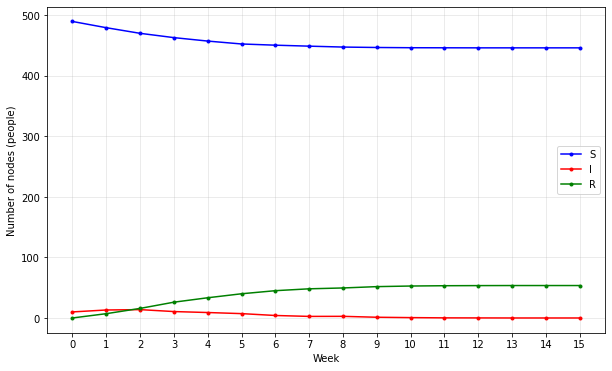

In [148]:
sir_plot(s, i, r, file="SIR_knownGraph.svg")

The plot below represent the new infection each week.

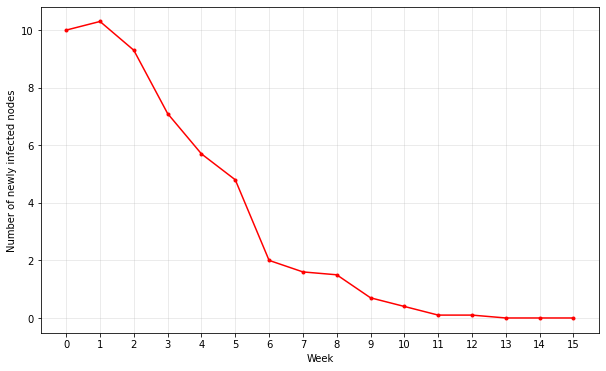

In [149]:
ni_plot(ni, file="NI_knownGraph.svg")

The previous simulation shows how nodes that are initialized randomly on the graph behave and propagate the infection. The epidemic slows down early and does not reach new nodes fast enough to infect most individuals in the population.
That because of the graph structure of the simulation almost reaches the absorbing configuration where susceptible represent the $90\%$ of the population whereas the other $10\%$ is represented by recovered (or dead there is no such distinction in this case) people.

## 1.2 Generate a random graph
From now on we will use random graphs with preferential attachment to run our simulations.

In [150]:
nodes = 1000
k_degree = 6
graph = generator_preferential_attachment(nodes, k_degree)
W = nx.adjacency_matrix(graph)
W = W.toarray()
w = np.sum(W, axis=1)
print("Average degree: ", np.mean(w))

Average degree:  6.0


## 2 Simulate a pandemic without vaccination

The second problem consists in simulating an epidemic based on the discrete-time SIR model using a preferential attachment random graph. In this case 100 simulations are performed as before and plot the average total number of susceptible, infected and recovered individuals each week and the average number of newly infected individuals each week.

The preferential attachment graph idea is the following:

- we start at time $t=0$ with an initial undirected graph $\mathcal{G}_0$;
- at each time $t \in \{1,2,...\}$, we create a new graph $\mathcal{G}_t$ obtained by adding a new node to $\mathcal{G}_{t-1}$, and connecting such a node to $c$ nodes randomly selected, according to a *preferential attachment* rule.

This rule says that at each time step $t$, the new node $n_t$ will have a degree $w_{n_t}(t)=\frac{k}{2}$. The nodes to which $n_t$ should connect are chosen according to the following probability rule.

The probability that there will be a link between node $n_t$ and node $i\in\mathcal{V}_{t-1}$ is:

$$
\mathbb{P}(W_{n_t,i}(t)=W_{i,n_t}(t)=1 \:\vert\: \mathcal{G}_{t-1} = ( \mathcal{V}_{t−1}, \mathcal{E}_{t−1}) = \frac{w_i(t-1)}{\sum_{j\in\mathcal{V}_{t-1}} w_j(t-1)}, \qquad i\in\mathcal{V}_{t-1}
$$


Each of the 100 simulations consists in the following steps.
* Generate a random graph according to the *preferential attachment model*, with average degree close to $k$.
* Simulate an epidemic according to the simplified version of the SIR model.

The parameters of the simulations $k$, number of nodes, $\beta$, $\rho$, number of steps and number of initially infected individuals are fixed for all 100 simulations.

In our simulations, a graph is generated with an average degree of $k=6$ and $500$ nodes. $\beta=0.3$ and $\rho=0.7$ are set as required by delivery, and carry out each simulation for $15$ weeks, with an initial configuration of $10$ infected nodes.

In [151]:
s, i, r, ni = epidemic(n_simulations=100,
                       type_graph="preferential_attachment",
                       k_neighbors= 6,
                       n_nodes=500,
                       beta=0.3,
                       rho=0.7,
                       n_weeks=15,
                       n_infected_init=10)

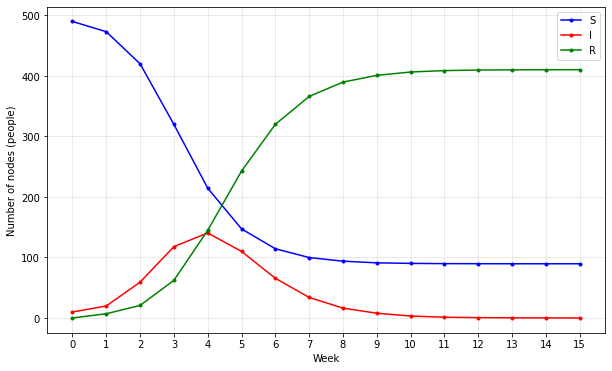

In [152]:
sir_plot(s, i, r, file="withoutvacc.svg")

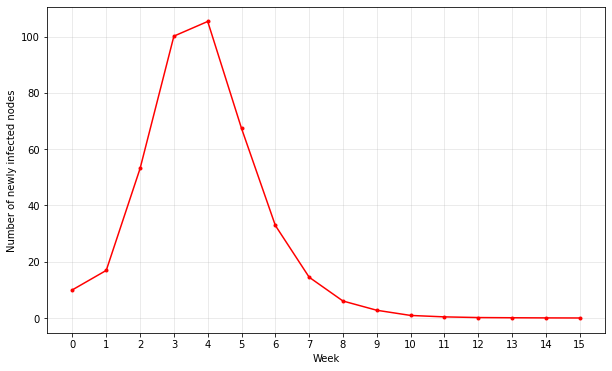

In [153]:
ni_plot(ni, file="withoutvaccNI.svg")

## 3 Simulate a pandemic with vaccination

In this part a SIR model takes into account **vaccinated individuals** as a separate state **V**. Vaccinated individuals are not able to become infected nor infect any other individual.

The state space becomes $\mathcal{A}=\{0, 1, 2, 3\}$ corresponding to **S** (susceptible), **I** (infected), **R** (recovered) and **V** (vaccinated) states.

The number of nodes to be vaccinated is determined by the array $\text{Vacc}(t)$. This array represents the total fraction of population that has received vaccination by the end of that week. It starts from $t=1$ and the first element of the array refers to the fraction of population that has received vaccination *by* week 1. The vaccination array given is:

$$\text{Vacc}(t) = [5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60, 60]$$

To clarify the idea, according to this array, $55\%$ of the population has received vaccination *by* week 7, i.e., in the time period that goes from the instant in which the simulation begins to the last instant of the 6th week, and $5\%$ of the population has received vaccination *during* week 7. Since we assume that the vaccination takes effect immediately once given, the nodes that receive vaccination during week 7 will not be able to become infected nor infect any other node in that same week 7, regardless of the state they were in immediately before the beginning of week 7.

An epidemic model based on the discrete-time SIR with vaccination (SIRV) is simulated. 100 simulations of this type are performed and a plot will show the average total number of susceptible, infected, recovered and vaccinated individuals each week and the average number of newly infected and newly vaccinated individuals each week.

In each of the 100 simulations, a graph is generated with average degree $k=6$ and $500$ nodes and simulated for $15$ weeks with parameters $\beta=0.3$, $\rho=0.7$ and an initial configuration of $10$ randomly chosen infected nodes. These settings are exactly the same as the previous simulation without vaccination, so results are more easily comparable.

In [154]:
vaccination_vector = [5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60, 60]

s, i, r, ni, v, nv = epidemic(n_simulations=100,
                              type_graph="preferential_attachment",
                              k_neighbors= 6,
                              n_nodes=500,
                              beta=0.3,
                              rho=0.7,
                              n_weeks=15,
                              n_infected_init=10,
                              vacc=vaccination_vector)

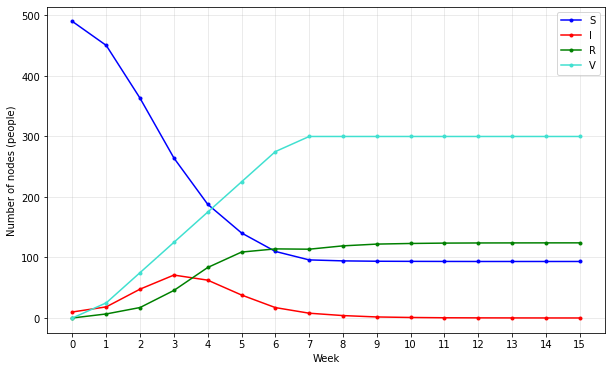

In [155]:
sir_plot(s, i, r, v, file="withvacc.svg")

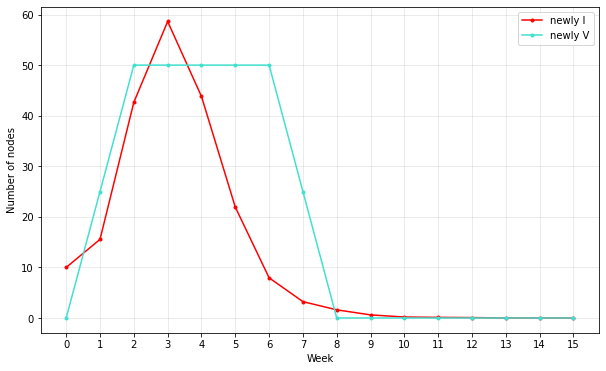

In [156]:
ninv_plot(ni, nv, file="withvaccNI.svg")

## 4 The H1N1 pandemic in Sweden 2009

Our goal is to estimate parameters $k$, $\beta$ and $\rho$ for our model which best match the **H1N1 pandemic in Sweden in 2009**, which we simulate for $15$ weeks. In the following vector is reported the fraction of population that had received vaccination during these weeks.

$$\text{Vacc}(t)=[5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]$$

The population of Sweden for computational purposes is scaled down to $934$ nodes. The number of newly infected individuals each week in the $15$-week period from week 42, 2009 to week 5, 2010 is reported in the following vector.
$$I_0(t)=[1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]$$

To estimate the parameters that best match the real pandemic, we define an algorithm which performs a **gradient-based search** over the parameter space of $k$, $\beta$ and $\rho$. 
The distance between our simulation and the real pandemic is measured through the root-mean-square error (RMSE) between the number of infected individuals each week $I(t)$ of the simulation and the number of infected individuals each week $I_0(t)$ of the real pandemic. This could be interpreted as the *cost function* of our algorithm.

$$\text{RMSE} = \sqrt{\frac{1}{n_\text{weeks}} \sum_{t=1}^{n_\text{weeks}} \left(I(t)-I_0(t)\right)^2 }\qquad \text{with}\; n_\text{weeks}=15\;\text{steps of the simulation}$$ 


### Algorithm 
The passages of algorithm are the following.
1. Fix an initial guess of the parameters $k_0=10$, $\beta_0=0.3$, $\rho_0=0.6$ and define $\Delta k=1$, $\Delta \beta = 0.1$, $\Delta \rho=0.1$ (then other initial combination are tried).
2. Construct the search space as a list of $3*3*3=27$ parameter sets, given by $\{k_0-\Delta k, k_0, k_0+\Delta k\} \times \{\beta_0-\Delta \beta, \beta_0, \beta_0+\Delta \beta\} \times \{\rho_0-\Delta \rho, \rho_0, \rho_0+\Delta \rho\}$.
3. For each parameter set $(k, \beta, \rho)$:
    1. Generate a random graph using the preferential attachment model with average degree $k$ and $934$ nodes.
    2. Simulate the pandemic 10 times, using the SIRV model with the given parameters.
    3. Compute the average number of newly infected individuals each week, $NI(t)$.
    4. Compute the RMSE between the simulation and the real pandemic.
4. Update $k_0$, $\beta_0$, $\rho_0$ to the set of parameters yielding the lowest RMSE.
5. If the best result achieve has the same set of parameters from the previous $k_0$, $\beta_0$, $\rho_0$ it stop and exit. Otherwise, return to 2.

To increase the variability of results an integer $\alpha$ variable is added to multiply the center of intervals $k_0$, $\beta_0$ and $\rho_0$. The basic idea is similar to the idea of Simulated Annealing: escape from a local minima and try to find a new parameters that could improve the general result. The main difference is that no cooling temperature is used.

For the simulation the starting parameters are the following instead:

* $k_o = 8$, $\Delta k = 1$,
* $\beta_o = 0.3$, $\Delta \beta = 0.025$,
* $\rho_o = 0.6$, $\Delta \rho = 0.025$,

In [157]:
vaccination_vector = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
infection_vector  =  [1, 1, 3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0,  0 ]
RMSE, new_k, new_beta, new_rho = search_parameters(vaccination_vector, infection_vector, 
                                                   type_graph = "preferential_attachment", 
                                                   k0 = 8, dk = 1, 
                                                   beta0 = 0.2, dbeta = 0.025, 
                                                   rho0 = 0.6, drho = 0.025)


Starting step 0 ...
Best RMSE 3.487
Previous parameter: k=8.000 beta=0.200 rho=0.600
Actual parameters : k=7.000 beta=0.225 rho=0.625
New Best result found ..........................

Starting step 1 ...
Best RMSE 5.446
Previous parameter: k=7.000 beta=0.225 rho=0.625
Actual parameters : k=7.000 beta=0.250 rho=0.625

Starting step 2 ...
Best RMSE 3.983
Previous parameter: k=7.000 beta=0.250 rho=0.625
Actual parameters : k=8.000 beta=0.250 rho=0.600

Starting step 3 ...
Best RMSE 4.374
Previous parameter: k=8.000 beta=0.250 rho=0.600
Actual parameters : k=9.000 beta=0.225 rho=0.600

Starting step 4 ...
Best RMSE 5.795
Previous parameter: k=9.000 beta=0.225 rho=0.600
Actual parameters : k=8.000 beta=0.200 rho=0.600

Starting step 5 ...
Best RMSE 3.963
Previous parameter: k=8.000 beta=0.200 rho=0.600
Actual parameters : k=7.000 beta=0.225 rho=0.625

Starting step 6 ...
Best RMSE 4.644
Previous parameter: k=7.000 beta=0.225 rho=0.625
Actual parameters : k=8.000 beta=0.200 rho=0.650

Start

In [158]:
vaccination_vector = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
print("Best result achieve: RMSE:{:.2f}, k:{:.2f}, Beta:{:.2f}, rho:{:.2f}".format( RMSE, new_k, new_beta, new_rho))

s, i, r, ni, v, nv = epidemic(n_simulations = 100,
                              type_graph="preferential_attachment",
                              k_neighbors = int(new_k),
                              n_nodes=934,
                              beta = new_beta,
                              rho = new_rho,
                              n_weeks=15,
                              n_infected_init=1,
                              vacc=vaccination_vector)
#best RMSE:2.64, k:9.00, Beta:0.175, rho:0.60

Best result achieve: RMSE:3.05, k:8.00, Beta:0.23, rho:0.57


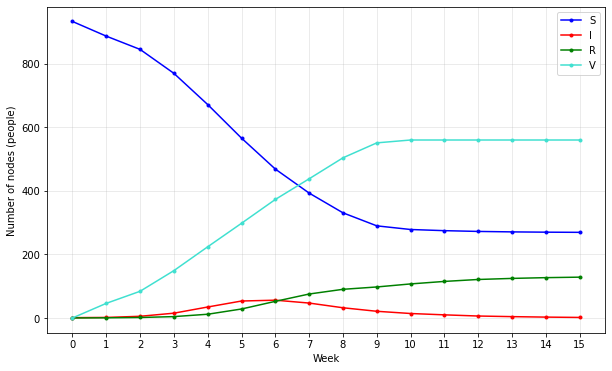

In [159]:
sir_plot(s, i, r, v, file="prefe.svg")

From the result we can observe, the RMSE cost generally tries to get lower as more steps are taken. However it remains still quite high despite the algorithm stops, indicating that the set of parameters that we found does not fit very well the real data.

Moreover, a huge number of parameters have been tried. This indicates that the variability of the experiment is quite high, and even by initializing the parameters to a fixed value and running several simulations per parameter set, we still have several sources of randomness. 
Finally, if we observe that it is evident how the RMSE loss oscillates and in general, the algorithm has some problem in converging. This may be due to the aforementioned variability of simulations, and also due to the algorithm finding a local minimum from which it is not able to escape.

Nonetheless, the best set of parameters found is $k=9$, $\beta=0.175$, $\rho=0.6$ associated with the lowest RMSE score, $2.64$.

Then our goal is to understand how well the model with optimal parameters actually fits the real epidemic. Therefore, we perform 100 simulations using the best set of parameters, and plot the average number of newly infected individuals each week compared to the true value of newly infected individuals each week $I_0(t)$, as well as the average total number of susceptible, infected, recovered and vaccinated individuals each week.

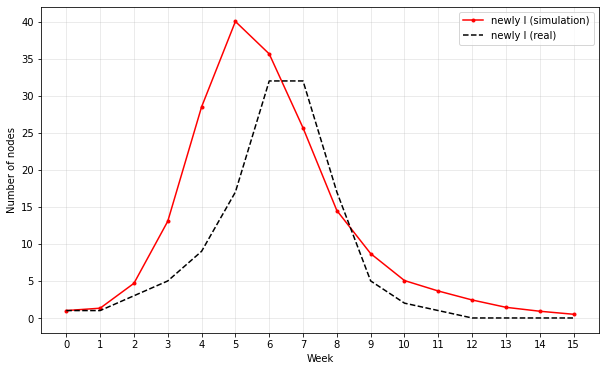

In [160]:
infection_vector = [1, 1,  3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0,  0,  0]
ni_comparison_plot(ni, infection_vector, file="prefeNI.svg")

The last plot clearly shows how the optimal parameter-set found does not fit very well the real epidemic curve. The most evident issue is that the number of newly infected individuals rises faster then real one, reaching a peak at week 5. It subsequently drops too early without ever reaching the actual number of newly infected of the real pandemic. Moreover, at the end from week 10, the number of newly infected nodes remains too high as the epidemic fades, in contrast with the more severe drop of the real epidemic.

# 5 Challenge

A potential problem with our algorithm, which we did not tackle before, may be the partial inadequacy of the preferential attachment graph. The social structure and the interactions between individuals of the population of Sweden may not be modelled very well with this kind of graph. In an attempt to solve this problem, another type of random graph is explored and run to search new best parameter on it, with the goal of further lowering the RMSE score and find a better fit for the real epidemic.

The graph model firstly choosed is the **Newman-Watts-Strogatz small-world model**. This model generates a random graph as follows. Firstly, it creates a ring over the $n$ nodes of the graph, each node connected to $k$ neighbors, $\frac{k}{2}$ on each side (or $k-1$ if $k$ is odd). We denote this underlying graph with $\mathcal{G}_u$. Then, for each edge $(i, j)$ in the underlying graph $\mathcal{G}_u$, it adds an edge $(i, k)$ with a randomly chosen existing node $w$ with probability $p$. In the end, it generates a random graph $\mathcal{G}$. Note that this is different from the Watts-Strogatz model, which instead *rewires* existing edges.

In this case, the parameter grid is composed by four different parameters, namely $k$ (number of nearest neighbors of the underlying graph), $p$ (probability of creating a new edge), $\beta$ and $\rho$. This means that the search space will be a list of $3*3*3*3=81$ parameter sets, given by $\{k_0-\Delta k, k_0, k_0+\Delta k\} \times \{p_0-\Delta p, p_0, p_0+\Delta p\} \times \{\beta_0-\Delta \beta, \beta_0, \beta_0+\Delta \beta\} \times \{\rho_0-\Delta \rho, \rho_0, \rho_0+\Delta \rho\}$.

For the simulation the starting parameters are the following:

* $k_o = 9$, $\Delta k = 1$,
* $\beta_o = 0.25$, $\Delta \beta = 0.025$,
* $\rho_o = 0.95$, $\Delta \rho = 0.025$

In [161]:
vaccination_vector = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
infection_vector = [1, 1, 3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0, 0]
RMSE, new_k, new_beta, new_rho, new_prob = search_parameters(vaccination_vector, infection_vector, 
                                                   type_graph = "newman_watts_strogatz", 
                                                   k0 = 9, dk = 1, 
                                                   beta0 = 0.25, dbeta = 0.025, 
                                                   rho0 = 0.95, drho = 0.025,
                                                   p0 = 0.5, dp = 0.025)



Starting step 0 ...
Best RMSE 4.646
Previous parameter: k=9.000 beta=0.250 rho=0.950 prob=0.525
Actual parameters : k=8.000 beta=0.250 rho=0.950 prob=0.475
New Best result found ..........................

Starting step 1 ...
Best RMSE 5.386
Previous parameter: k=8.000 beta=0.250 rho=0.950 prob=0.500
Actual parameters : k=8.000 beta=0.225 rho=0.925 prob=0.450

Starting step 2 ...
Best RMSE 4.978
Previous parameter: k=8.000 beta=0.225 rho=0.925 prob=0.475
Actual parameters : k=8.000 beta=0.250 rho=0.925 prob=0.475

Starting step 3 ...
Best RMSE 4.779
Previous parameter: k=8.000 beta=0.250 rho=0.925 prob=0.500
Actual parameters : k=9.000 beta=0.250 rho=0.950 prob=0.450

Starting step 4 ...
Best RMSE 4.703
Previous parameter: k=9.000 beta=0.250 rho=0.950 prob=0.475
Actual parameters : k=9.000 beta=0.250 rho=0.925 prob=0.475

Starting step 5 ...
Best RMSE 4.956
Previous parameter: k=9.000 beta=0.250 rho=0.925 prob=0.500
Actual parameters : k=8.000 beta=0.225 rho=0.900 prob=0.450

Starting

In [168]:
vaccination_vector = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
print("Best result achieve: RMSE:{:.3f}, k:{:.3f}, Beta:{:.3f}, rho:{:.3f}, p:{:.3f}".format( RMSE, new_k, new_beta, new_rho, new_prob))

s, i, r, ni, v, nv = epidemic(n_simulations = 100,
                              type_graph = "newman_watts_strogatz",
                              k_neighbors = int(new_k),
                              n_nodes = 934,
                              beta = new_beta,
                              rho = new_rho,
                              n_weeks = 15,
                              n_infected_init=1,
                              vacc = vaccination_vector,
                              prob = new_prob)
# Best result achieve: RMSE:3.733, k:9.000, Beta:0.250, rho:1.000, p:0.500

Best result achieve: RMSE:3.733, k:9.000, Beta:0.250, rho:1.000, p:0.500


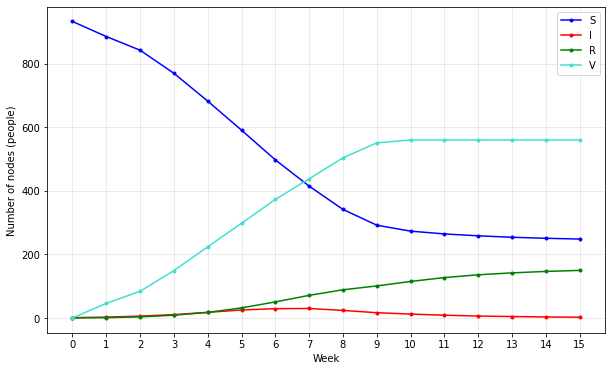

In [169]:
sir_plot(s, i, r, v, file="newman.svg")

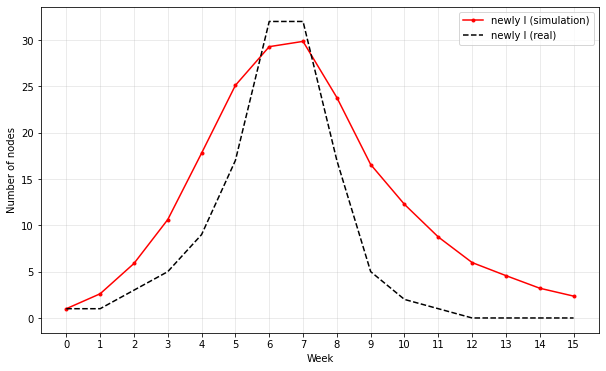

In [174]:
infection_vector = [1, 1, 3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0, 0, 0]
ni_comparison_plot(ni, infection_vector, file="newmanNI.svg") 

From the multiple run, the best set of parameters found is $k=9$, $\beta=0.25$, $\rho=1$ and $probability=0.5$ associated with the lowest RMSE score, $3.73$.
The previous plot shows that the Newman-Watts-Strogatz model does not fit the real epidemic trend better than the preferential attachment model. The curve don't change so much. While it partially solves the problem of the epidemic peaking too early, the number of newly infected remains excessively high before and in particular after the peak number of newly infected. Most importantly, the peak number of newly infected is never reached, but remains well under the peak of the real epidemic.

So we may assume that:
* The RMSE function is inadequate as loss function for this type of models.
* Isolated people with small contact each other are not considered. Sweden is a huge country with a low density.

In conclusion, we acknowledge that both models have problems in fitting the real epidemic, and more extensive research is needed to find a model and a combination of parameters that fit better the trend.